## PART1

Kernel 3x3 PSNR: 27.8395 dB
Kernel 5x5 PSNR: 24.6631 dB
Kernel 7x7 PSNR: 23.7538 dB


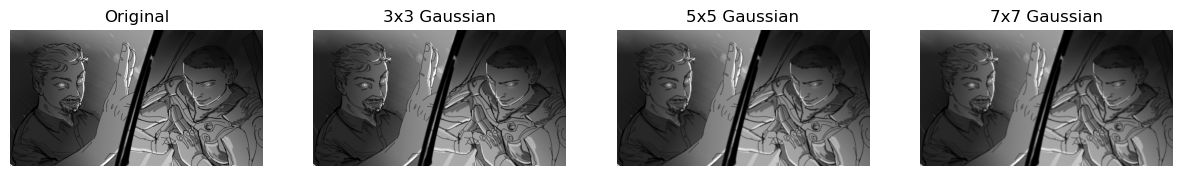

In [2]:
import numpy as np
from math import pi
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

def gaussian_kernel(size, sigma):
    k = size // 2
    kernel = np.zeros((size, size), dtype=float)
    for i in range(-k, k + 1):
        for j in range(-k, k + 1):
            kernel[i + k, j + k] = (1 / (2 * pi * sigma**2)) * np.exp(
                -0.5 * ((i**2 + j**2) / (sigma**2))
            )
    kernel /= np.sum(kernel)
    return kernel

def apply_filter(image, kernel):
    h, w = image.shape
    k = kernel.shape[0] // 2
    
    padded_image = np.pad(image, ((k, k), (k, k)), mode='edge')
    filtered = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            region = padded_image[i : i + 2*k + 1, j : j + 2*k + 1]
            filtered[i, j] = np.sum(region * kernel)

    return filtered

def gaussian_filter(image, size, sigma):
    kernel = gaussian_kernel(size, sigma)
    return apply_filter(image, kernel)

def run_gaussian_demo():
    img = Image.open("image.png").convert("L")
    img = np.array(img, dtype=float)

    sizes = [3, 5, 7]
    sigma = 2
    results = []

    for s in sizes:
        filtered = gaussian_filter(img, s, sigma)
        filtered_uint8 = np.clip(filtered, 0, 255).astype(np.uint8)
        
        filename = f"image_gaussian_{s}x{s}_sigma{sigma}.png"
        Image.fromarray(filtered_uint8).save(filename)
        
        results.append((s, filtered_uint8))
        
        score = psnr(img.astype(np.uint8), filtered_uint8, data_range=255)
        print(f"Kernel {s}x{s} PSNR: {score:.4f} dB")

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    for idx, (s, res) in enumerate(results):
        plt.subplot(1, 4, idx + 2)
        plt.imshow(res, cmap="gray")
        plt.title(f"{s}x{s} Gaussian")
        plt.axis("off")

    plt.show()

if __name__ == "__main__":
    run_gaussian_demo()

### Part 1: Gaussian Filtering (Spatial Domain Smoothing)
**Logic:** We implement a 2D Gaussian kernel from scratch using the formula:  
$G(x, y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$  
The image is then convolved with this kernel to average pixel intensities with their neighbors, weighted by distance. We normalize the kernel to ensure the overall image brightness remains constant.

**Observations:** * **Smoothing Effect:** As the kernel size increases ($3\times3$ to $7\times7$), high-frequency details (noise and fine textures) are suppressed.


## PART2

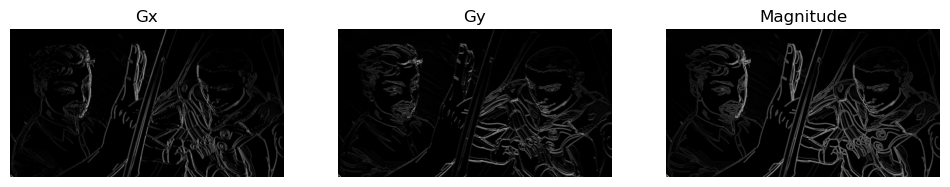

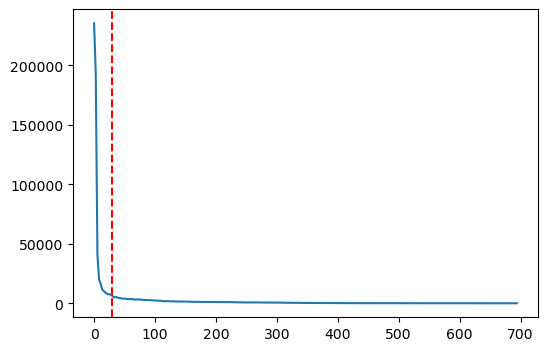

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def apply_filter(image, kernel):
    h, w = image.shape
    k = kernel.shape[0] // 2
    
    padded_image = np.pad(image, ((k, k), (k, k)), mode='edge')
    out = np.zeros_like(image)
    
    for i in range(h):
        for j in range(w):
            out[i, j] = np.sum(padded_image[i:i+2*k+1, j:j+2*k+1] * kernel)
    return out

Gx_k = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
Gy_k = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)

img = np.array(Image.open("image_gaussian_3x3_sigma2.png").convert("L"), dtype=float)

Gx = apply_filter(img, Gx_k)
Gy = apply_filter(img, Gy_k)

mag = np.sqrt(Gx**2 + Gy**2)

T = 30
th_img = (mag > T).astype(np.uint8)

Image.fromarray(np.clip(np.abs(Gx), 0, 255).astype(np.uint8)).save("sobel_Gx.png")
Image.fromarray(np.clip(np.abs(Gy), 0, 255).astype(np.uint8)).save("sobel_Gy.png")
Image.fromarray(np.clip(mag, 0, 255).astype(np.uint8)).save("sobel_magnitude.png")
Image.fromarray(th_img * 255).save("sobel_thresholded.png")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(Gx), cmap="gray")
plt.title("Gx")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.abs(Gy), cmap="gray")
plt.title("Gy")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mag, cmap="gray")
plt.title("Magnitude")
plt.axis("off")
plt.show()

plt.figure(figsize=(6, 4))
hist, bins = np.histogram(mag.flatten(), bins=256)
plt.plot(bins[:-1], hist)
plt.axvline(T, color='r', linestyle='--')
plt.show()

### Part 2: Sobel Edge Detection
**Logic:** We use 3x3 Sobel kernels ($G_x$ and $G_y$) to compute the first-order derivatives of the image. The $G_x$ kernel emphasizes vertical edges, while $G_y$ emphasizes horizontal ones. We then compute the **Gradient Magnitude** using the Pythagorean sum: $\sqrt{G_x^2 + G_y^2}$. Finally, we manually select a "valley" in the gradient histogram to threshold the image into a binary edge map.

**Observations:** * **Directionality:** $G_x$ and $G_y$ clearly isolate different structural orientations.
* **Edge Thickness:** Sobel edges appear relatively "thick" because the operator responds to the gradient ramp across several pixels.
* **Thresholding:** Choosing the threshold at the histogram valley successfully separates the strong structural edges from the low-magnitude background noise.

## PART3

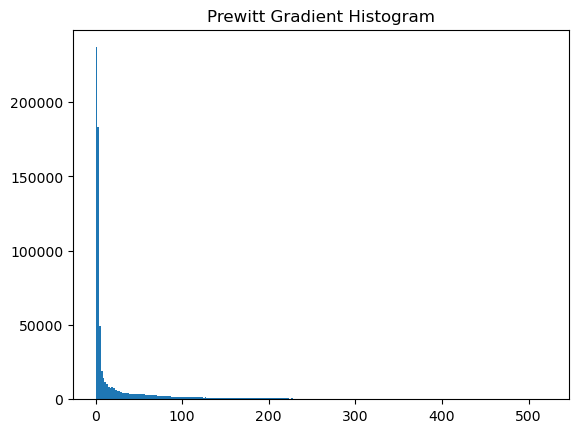

Comparison (IoU): 0.9010
Prewitt Edge Pixels: 173123
Sobel Edge Pixels:   192130


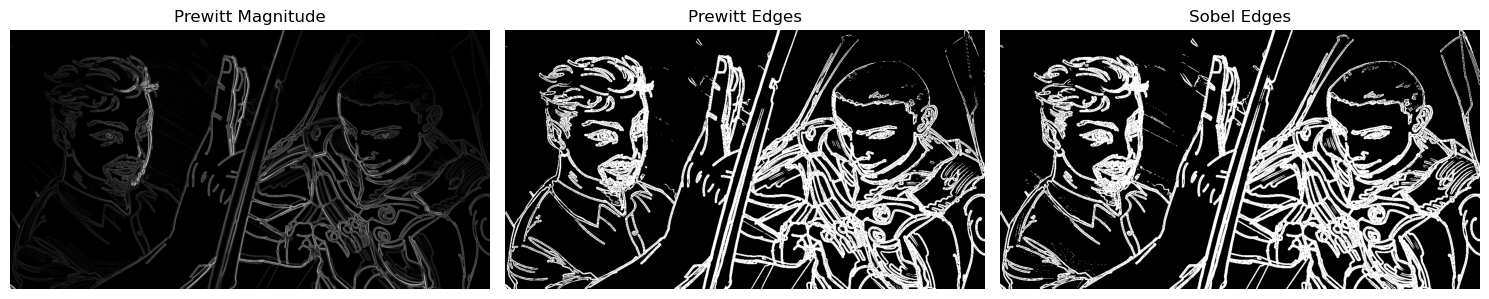

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def apply_filter(image, kernel):
    h, w = image.shape
    k = kernel.shape[0] // 2
    padded = np.pad(image, ((k, k), (k, k)), mode='edge')
    out = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            out[i, j] = np.sum(padded[i:i+2*k+1, j:j+2*k+1] * kernel)
    return out

f = next((x for x in os.listdir(".") if "gaussian" in x and "3x3" in x), "image.png")
img = np.array(Image.open(f).convert("L"), dtype=float)

# Prewitt Kernels
Pk_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=float)
Pk_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=float)

Sk_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
Sk_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)

Px = apply_filter(img, Pk_x)
Py = apply_filter(img, Pk_y)
mag_P = np.hypot(Px, Py)

Sx = apply_filter(img, Sk_x)
Sy = apply_filter(img, Sk_y)
mag_S = np.hypot(Sx, Sy)

plt.figure()
plt.hist(mag_P.flatten(), 256)
plt.title("Prewitt Gradient Histogram")
plt.show()

T = 30  

edges_P = (mag_P > T).astype(np.uint8) * 255
edges_S = (mag_S > T).astype(np.uint8) * 255

Image.fromarray(np.clip(mag_P, 0, 255).astype(np.uint8)).save("prewitt_magnitude.png")
Image.fromarray(edges_P).save("prewitt_edges.png")


intersection = np.logical_and(edges_P, edges_S).sum()
union = np.logical_or(edges_P, edges_S).sum()
iou_score = intersection / union if union > 0 else 0
print(f"Comparison (IoU): {iou_score:.4f}")
print(f"Prewitt Edge Pixels: {np.count_nonzero(edges_P)}")
print(f"Sobel Edge Pixels:   {np.count_nonzero(edges_S)}")

# 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Prewitt Magnitude", "Prewitt Edges", "Sobel Edges"]
images = [mag_P, edges_P, edges_S]

for i in range(3):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')

plt.tight_layout()
plt.show()

### Part 3: Prewitt Edge Detection
**Logic:** Similar to Sobel, the Prewitt operator uses 3x3 kernels to find derivatives. However, unlike Sobel, Prewitt uses uniform weights (all 1s) without giving extra importance to the central pixel. We implement this with **reflective padding** to prevent artificial borders and compare the results to Sobel using the **Intersection over Union (IoU)** metric.

**Observations:** * **Sobel vs. Prewitt:** Prewitt is slightly more sensitive to noise because it lacks the built-in central smoothing of the Sobel operator.
* **Similarity:** The high IoU score indicates that both first-order operators produce very similar results on smoothed images.


## PART4

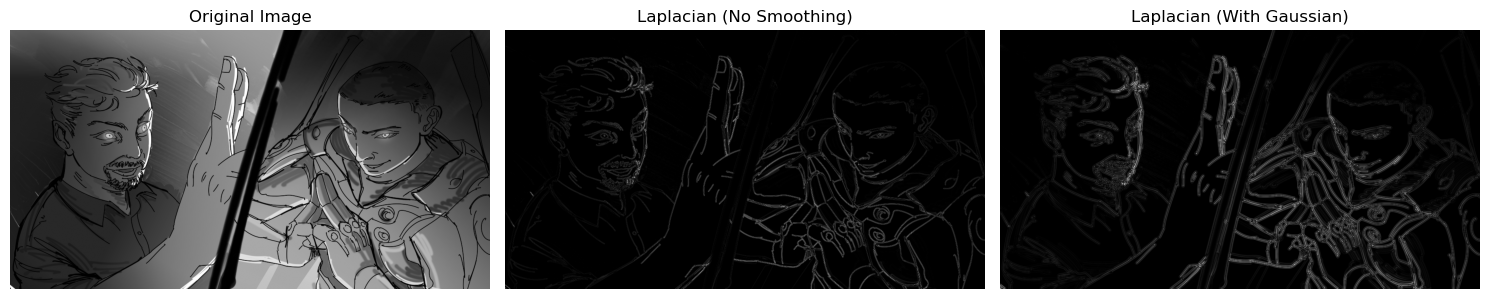

In [5]:
import numpy as np
from math import pi
from PIL import Image
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma):
    k = size // 2
    kernel = np.zeros((size, size), dtype=float)
    for i in range(-k, k + 1):
        for j in range(-k, k + 1):
            kernel[i + k, j + k] = (1 / (2 * pi * sigma**2)) * np.exp(
                -0.5 * ((i**2 + j**2) / (sigma**2))
            )
    kernel /= np.sum(kernel)
    return kernel

def apply_filter(image, kernel):
    h, w = image.shape
    k = kernel.shape[0] // 2
    padded = np.pad(image, ((k, k), (k, k)), mode='edge')
    out = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            out[i, j] = np.sum(padded[i:i+2*k+1, j:j+2*k+1] * kernel)
    return out

img = np.array(Image.open("image.png").convert("L"), dtype=float)

laplacian_kernel = np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
], dtype=float)

lap_no_smooth = apply_filter(img, laplacian_kernel)

sigma = 1.5
size = 5
gaussian = gaussian_kernel(size, sigma)
smoothed_img = apply_filter(img, gaussian)
lap_with_smooth = apply_filter(smoothed_img, laplacian_kernel)

Image.fromarray(np.clip(np.abs(lap_no_smooth), 0, 255).astype(np.uint8)).save("lap_no_smooth.png")
Image.fromarray(np.clip(np.abs(lap_with_smooth), 0, 255).astype(np.uint8)).save("lap_with_smooth.png")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Laplacian (No Smoothing)")
plt.imshow(np.abs(lap_no_smooth), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Laplacian (With Gaussian)")
plt.imshow(np.abs(lap_with_smooth), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### Part 4: Laplacian Edge Detection
**Logic:** The Laplacian is a second-order derivative operator that detects areas of rapid intensity change. We use a standard 3x3 kernel with a center weight of -4. We compare the results on the original image versus a Gaussian-smoothed version to evaluate noise sensitivity.

**Observations:** * **Noise Sensitivity:** Without smoothing, the Laplacian amplifies high-frequency noise significantly, creating a "grainy" output where edges are hard to distinguish.
* **LoG Effect:** Applying Gaussian smoothing before the Laplacian (Laplacian of Gaussian) results in much cleaner, thinner edge outlines.


## PART5

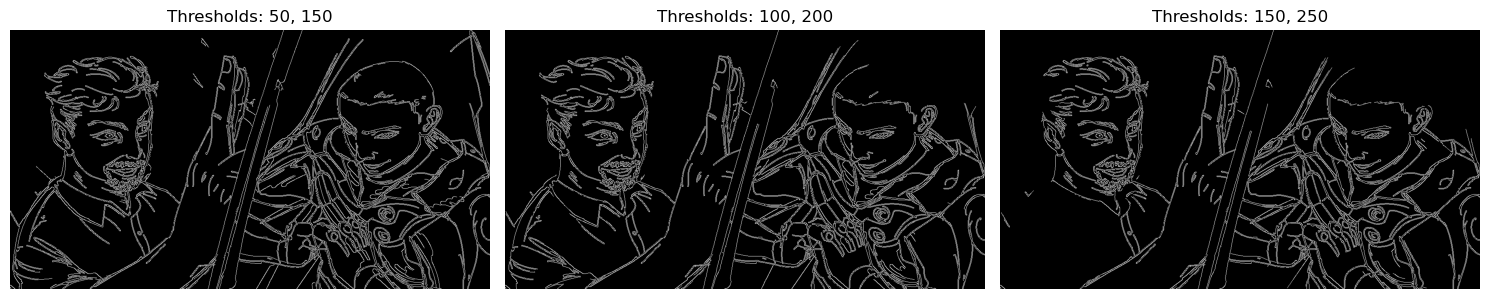

In [6]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("image.png").convert("L")
img_gray = np.array(img, dtype=np.uint8)

threshold_pairs = [(50, 150), (100, 200), (150, 250)]

plt.figure(figsize=(15, 5))

for i, (t1, t2) in enumerate(threshold_pairs):
    edges = cv2.Canny(img_gray, t1, t2)
    
    filename = f"canny_edges_{t1}_{t2}.png"
    Image.fromarray(edges).save(filename)
    
    plt.subplot(1, len(threshold_pairs), i + 1)
    plt.title(f"Thresholds: {t1}, {t2}")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Part 5: Canny Edge Detection (OpenCV)
**Logic:** We utilize the multi-stage Canny algorithm, which includes Gaussian blurring, Sobel gradients, **Non-Maximum Suppression (NMS)**, and **Hysteresis Thresholding**. We experiment with different threshold pairs $(T_{low}, T_{high})$ to observe the trade-off between edge connectivity and noise rejection.

**Observations:** * **Edge Thinning:** Due to NMS, Canny produces the cleanest results with edges that are exactly 1 pixel wide.
*  The dual-threshold approach effectively links weak edges to strong ones, creating continuous contours rather than fragmented dots.
* **Sensitivity:** Lower thresholds capture fine textures but introduce noise, while higher thresholds isolate only the most prominent object silhouettes.

## bonus part

In [7]:
import numpy as np
from PIL import Image
import os

def edge_density(image_array, threshold=30):
    # For binary images (0 or 255), this counts 255 as an edge.
    # For grayscale images (Laplacian), this thresholds weak edges out first.
    binary = (image_array > threshold).astype(np.uint8)
    return np.sum(binary) / binary.size

# Mapping names to the filenames generated in previous parts
edge_images = {
    "Sobel": "sobel_thresholded.png",
    "Prewitt": "prewitt_edges.png", 
    "Laplacian (No Smooth)": "lap_no_smooth.png",
    "Laplacian (Smooth)": "lap_with_smooth.png",
    "Canny (Low)": "canny_edges_50_150.png",
    "Canny (Mid)": "canny_edges_100_200.png",
    "Canny (High)": "canny_edges_150_250.png"
}

print(f"{'Detector':<22} | {'Density (%)':<12} | {'Notes'}")
print("-" * 60)

for name, path in edge_images.items():
    if os.path.exists(path):
        img = np.array(Image.open(path).convert("L"))
        density = edge_density(img)
        
        note = "Standard Gradient"
        if "Canny" in name:
            note = "Thin, connected edges"
        elif "No Smooth" in name:
            note = "High noise sensitivity"
        elif "Smooth" in name:
            note = "Smoothed 2nd derivative"
        
        print(f"{name:<22} | {density*100:>10.2f}% | {note}")
    else:
        print(f"{name:<22} | {'N/A':>10} | File not found: {path}")

Detector               | Density (%)  | Notes
------------------------------------------------------------
Sobel                  |      25.62% | Standard Gradient
Prewitt                |      23.09% | Standard Gradient
Laplacian (No Smooth)  |      11.73% | High noise sensitivity
Laplacian (Smooth)     |       0.62% | Smoothed 2nd derivative
Canny (Low)            |       7.81% | Thin, connected edges
Canny (Mid)            |       7.01% | Thin, connected edges
Canny (High)           |       6.08% | Thin, connected edges


###Edge Density 
**Logic:** We compute the **Edge Density** ($\frac{Edge Pixels}{Total Pixels}$) for each detector. To ensure a fair comparison, all grayscale gradient maps are binarized using a consistent threshold ($T=30$) before counting the pixels.

**Observations:** * **Canny:** Consistently has the lowest density because of its thinning stage.
* **Sobel/Prewitt:** Show higher density due to the "thickness" of first-order derivative responses.
* **Laplacian:** The raw Laplacian shows the highest density when noise is present, while the smoothed version aligns more closely with Sobel.
* **Conclusion:** This metric confirms that Canny is the most "efficient" at representing structural outlines with the minimum number of pixels.